
# Pinn Solver Uses 

---

In this notebook, I will be using PInns to solve some useful laplace boundry problems which are not very straightfoward to solve using the analytic and numerical methods


In [ ]:
import tensorflow as tf
import numpy as np

DTYPE='float32' 
tf.keras.backend.set_floatx(DTYPE)

pi = tf.constant(np.pi, dtype=DTYPE) 
# Defining boundry:
def boundryfun(y):
  return  tf.sin(6*pi*y) 

def boundryfun1(y):
  return  tf.sin(-6*pi*y) 

def boundryfun2(x,y):   
  n = x.shape[0]
  return tf.zeros((n,1), dtype=DTYPE)  

def residual(x, y, z, z_x, z_y, z_xx, z_yy):
  return z_xx + z_yy

# Setting Data points:
N_b = 500     
N_r = 10000

# Setting Boundry:    
xmin = 0.0
xmax = 1.0
ymin = 0.0
ymax = 1.0

lb = tf.constant([xmin, ymin], dtype = DTYPE)
ub = tf.constant([xmax, ymax], dtype = DTYPE)

tf.random.set_seed(0) 
# Boundry Value data
x_b = tf.ones((N_b, 1), dtype = DTYPE)*lb[0]
y_b = tf.random.uniform((N_b, 1), lb[1], ub[1], dtype = DTYPE)  
X_b = tf.concat([y_b, x_b], axis = 1)
z_b = boundryfun(y_b)                      
# Boundry Value1 and 2 data
x_b1 = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype = DTYPE)
y_b1 = tf.ones((N_b, 1), dtype = DTYPE)*lb[1]
X_b1 = tf.concat([y_b1, x_b1], axis = 1)   
z_b1 = tf.zeros((N_b, 1), dtype = DTYPE)

x_b2 = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype = DTYPE)
y_b2 = tf.ones((N_b, 1), dtype = DTYPE)*ub[1]
X_b2 = tf.concat([y_b2, x_b2], axis = 1)
z_b2 = tf.zeros((N_b, 1), dtype = DTYPE)

x_b3 = tf.ones((N_b, 1), dtype = DTYPE)*ub[0]
y_b3 = tf.random.uniform((N_b, 1), lb[1], ub[1], dtype = DTYPE)
X_b3 = tf.concat([y_b3, x_b3], axis = 1)
z_b3 = boundryfun1(y_b3)

# Residual Points (Coallocation Points)
x_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)   
y_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([y_r, x_r], axis = 1)

# Net data
X_data = [X_b, X_b1, X_b2, X_b3]
Z_data = [z_b, z_b1, z_b2, z_b3]

[Text(0.5, 0, '$y$'), Text(0.5, 0, '$x$')]

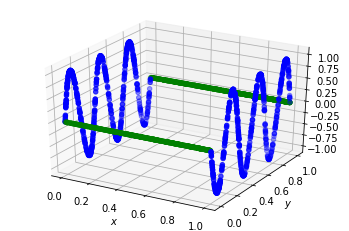

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.scatter3D(x_b, y_b, z_b, color = 'blue')
ax.scatter3D(x_b1, y_b1, z_b1, color = 'green')
ax.scatter3D(x_b2, y_b2, z_b2, color = 'green')
ax.scatter3D(x_b3, y_b3, z_b3, color = 'blue')
ax.set(xlabel = '$x$', ylabel ='$y$' )

In [ ]:
def init_model(num_hidden_layers=9, num_neurons_per_layer=20):
    model = tf.keras.Sequential() 
    model.add(tf.keras.Input(2))  
    scaling_layer = tf.keras.layers.Lambda(lambda x: 2.0*(x - lb)/(ub - lb) - 1.0) 
    model.add(scaling_layer)  
    for i in range(num_hidden_layers):     
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,activation=tf.keras.activations.get('tanh'),
                                        kernel_initializer='glorot_normal'))  #

    model.add(tf.keras.layers.Dense(1))   
    return model

In [ ]:
def get_residual(model, X_r):

  with tf.GradientTape(persistent = True) as tape:
    y, x = X_r[:, 0:1], X_r[:,1:2] 
    tape.watch(y)
    tape.watch(x)

    z = model(tf.stack([y[:,0], x[:,0]], axis=1)) 
    z_x = tape.gradient(z, x)    
    z_y = tape.gradient(z, y)

  z_yy = tape.gradient(z_y, y)
  z_xx = tape.gradient(z_x, x)

  del tape

  return residual(x, y, z, z_x, z_y, z_xx, z_yy)

##################################### Calculating the loss function:

def compute_loss(model, X_r, X_data, Z_data, lmbd = 10**-5):

  r = get_residual(model, X_r)          
  rloss = tf.reduce_mean(tf.square(r))  

  loss = lmbd*(rloss)
  for i in range(len(X_data)):
      Z_pred = model(X_data[i])   
      loss += tf.reduce_mean(tf.square(Z_data[i] - Z_pred))
    
  return loss

########################################### Getting gradients
def get_grad(model, X_r, X_data, Z_data):
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, Z_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [ ]:
########################################### Initialising the model
model = init_model()
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

########################################### Training the model
from time import time

@tf.function
def train_step():
    loss, grad_theta = get_grad(model, X_r, X_data, Z_data)
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    return loss

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()
for i in range(N+1):
    loss = train_step()
    hist.append(loss.numpy())
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
print('\nComputation time: {} seconds'.format(time()-t0))
###########################################

It 00000: loss = 1.09170508e+00
It 00050: loss = 9.62340593e-01
It 00100: loss = 7.83858061e-01
It 00150: loss = 6.17516577e-01
It 00200: loss = 3.92644972e-01
It 00250: loss = 3.91507864e-01
It 00300: loss = 1.94047198e-01
It 00350: loss = 1.65426195e-01
It 00400: loss = 1.08348012e-01
It 00450: loss = 6.17309548e-02
It 00500: loss = 3.66968773e-02
It 00550: loss = 3.41571197e-02
It 00600: loss = 1.52566694e-02
It 00650: loss = 7.24951029e-02
It 00700: loss = 1.13668516e-01
It 00750: loss = 9.82674025e-03
It 00800: loss = 7.60601647e-03
It 00850: loss = 8.13952088e-03
It 00900: loss = 1.21424887e-02
It 00950: loss = 1.79240983e-02
It 01000: loss = 3.41525190e-02
It 01050: loss = 6.79084286e-03
It 01100: loss = 6.15045615e-03
It 01150: loss = 5.86989243e-03
It 01200: loss = 5.69534395e-03
It 01250: loss = 5.56895742e-03
It 01300: loss = 5.46985911e-03
It 01350: loss = 5.38768480e-03
It 01400: loss = 5.31629194e-03
It 01450: loss = 5.25183138e-03
It 01500: loss = 5.19192033e-03
It 01550

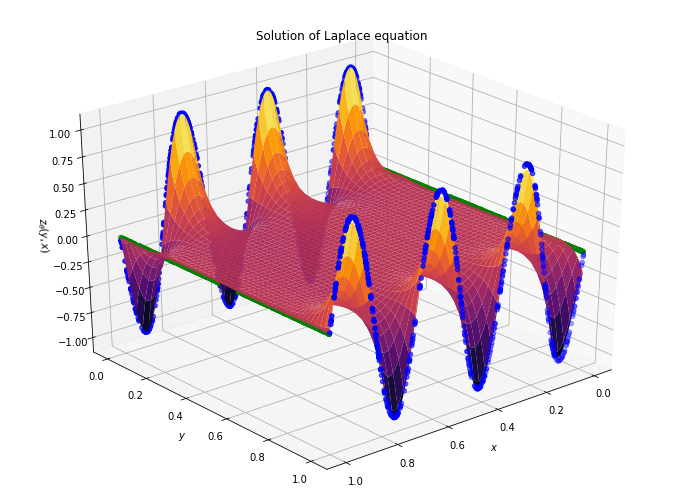

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
yspace = np.linspace(lb[0], ub[0] , N + 1)
xspace = np.linspace(lb[1], ub[1] , N + 1)
Y, X = np.meshgrid(yspace, xspace)
Xgrid = np.vstack([Y.flatten(),X.flatten()]).T  
zpred = model(tf.cast(Xgrid,DTYPE))   
Z = zpred.numpy().reshape(N+1,N+1)  

fig = plt.figure(figsize=(12,9))
#fig.set(figwidth = 12, figheight = 9)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y, X, Z, cmap='inferno');
ax.view_init(35,35)

ax.scatter3D(y_b, x_b, z_b, color = 'blue')
ax.scatter3D(y_b1, x_b1, z_b1, color = 'green')
ax.scatter3D(y_b2, x_b2, z_b2, color = 'green')
ax.scatter3D(y_b3, x_b3, z_b3, color = 'blue')


ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z_\\theta(y,x)$')
ax.set_title('Solution of Laplace equation');
ax.view_init(azim = 50)

Solving an assymetric Laplace boundry Equation

In [ ]:
import tensorflow as tf
import numpy as np

DTYPE='float32' 
tf.keras.backend.set_floatx(DTYPE)

pi = tf.constant(np.pi, dtype=DTYPE) 
# Defining boundry:
def boundryfun(y):
  return 3*y*(1-y)*(4*y+1)     #tf.sin(6*pi*y) 

def boundryfun1(y):
  return -3*y*(1-y)*(4/(y+1)+1)  #tf.sin(-6*pi*y) 

def boundryfun2(x,y):   
  n = x.shape[0]
  return tf.zeros((n,1), dtype=DTYPE)  

def residual(x, y, z, z_x, z_y, z_xx, z_yy):
  return z_xx + z_yy

# Setting Data points:
N_b = 500     
N_r = 10000

# Setting Boundry:    
xmin = 0.0
xmax = 1.0
ymin = 0.0
ymax = 1.0

lb = tf.constant([xmin, ymin], dtype = DTYPE)
ub = tf.constant([xmax, ymax], dtype = DTYPE)

tf.random.set_seed(0) 
# Boundry Value data
x_b = tf.ones((N_b, 1), dtype = DTYPE)*lb[0]
y_b = tf.random.uniform((N_b, 1), lb[1], ub[1], dtype = DTYPE)  
X_b = tf.concat([y_b, x_b], axis = 1)
z_b = boundryfun(y_b)                      
# Boundry Value1 and 2 data
x_b1 = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype = DTYPE)
y_b1 = tf.ones((N_b, 1), dtype = DTYPE)*lb[1]
X_b1 = tf.concat([y_b1, x_b1], axis = 1)   
z_b1 = tf.zeros((N_b, 1), dtype = DTYPE)

x_b2 = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype = DTYPE)
y_b2 = tf.ones((N_b, 1), dtype = DTYPE)*ub[1]
X_b2 = tf.concat([y_b2, x_b2], axis = 1)
z_b2 = tf.zeros((N_b, 1), dtype = DTYPE)

x_b3 = tf.ones((N_b, 1), dtype = DTYPE)*ub[0]
y_b3 = tf.random.uniform((N_b, 1), lb[1], ub[1], dtype = DTYPE)
X_b3 = tf.concat([y_b3, x_b3], axis = 1)
z_b3 = boundryfun1(y_b3)

# Residual Points (Coallocation Points)
x_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)   
y_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([y_r, x_r], axis = 1)

# Net data
X_data = [X_b, X_b1, X_b2, X_b3]
Z_data = [z_b, z_b1, z_b2, z_b3]

[Text(0.5, 0, '$y$'), Text(0.5, 0, '$x$')]

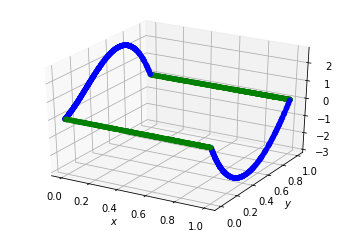

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.scatter3D(x_b, y_b, z_b, color = 'blue')
ax.scatter3D(x_b1, y_b1, z_b1, color = 'green')
ax.scatter3D(x_b2, y_b2, z_b2, color = 'green')
ax.scatter3D(x_b3, y_b3, z_b3, color = 'blue')
ax.set(xlabel = '$x$', ylabel ='$y$' )

In [ ]:
def init_model(num_hidden_layers=9, num_neurons_per_layer=20):
    model = tf.keras.Sequential() 
    model.add(tf.keras.Input(2))  
    scaling_layer = tf.keras.layers.Lambda(lambda x: 2.0*(x - lb)/(ub - lb) - 1.0) 
    model.add(scaling_layer)  
    for i in range(num_hidden_layers):     
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,activation=tf.keras.activations.get('tanh'),
                                        kernel_initializer='glorot_normal'))  #

    model.add(tf.keras.layers.Dense(1))   
    return model

In [ ]:
def get_residual(model, X_r):

  with tf.GradientTape(persistent = True) as tape:
    y, x = X_r[:, 0:1], X_r[:,1:2] 
    tape.watch(y)
    tape.watch(x)

    z = model(tf.stack([y[:,0], x[:,0]], axis=1)) 
    z_x = tape.gradient(z, x)    
    z_y = tape.gradient(z, y)

  z_yy = tape.gradient(z_y, y)
  z_xx = tape.gradient(z_x, x)

  del tape

  return residual(x, y, z, z_x, z_y, z_xx, z_yy)

##################################### Calculating the loss function:

def compute_loss(model, X_r, X_data, Z_data, lmbd = 10**-5):

  r = get_residual(model, X_r)          
  rloss = tf.reduce_mean(tf.square(r))  

  loss = lmbd*(rloss)
  for i in range(len(X_data)):
      Z_pred = model(X_data[i])   
      loss += tf.reduce_mean(tf.square(Z_data[i] - Z_pred))
    
  return loss

########################################### Getting gradients
def get_grad(model, X_r, X_data, Z_data):
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, Z_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [ ]:
########################################### Initialising the model
model = init_model()
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

########################################### Training the model
from time import time

@tf.function
def train_step():
    loss, grad_theta = get_grad(model, X_r, X_data, Z_data)
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    return loss

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()
for i in range(N+1):
    loss = train_step()
    hist.append(loss.numpy())
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
print('\nComputation time: {} seconds'.format(time()-t0))
###########################################

It 00000: loss = 7.01929379e+00
It 00050: loss = 5.41086234e-02
It 00100: loss = 3.51222083e-02
It 00150: loss = 1.75316557e-02
It 00200: loss = 1.72704235e-02
It 00250: loss = 1.53064448e-02
It 00300: loss = 1.38705149e-02
It 00350: loss = 8.51743389e-03
It 00400: loss = 2.87004877e-02
It 00450: loss = 8.70955549e-03
It 00500: loss = 4.38182987e-03
It 00550: loss = 8.02168809e-03
It 00600: loss = 2.74506561e-03
It 00650: loss = 2.49672029e-03
It 00700: loss = 5.87646477e-03
It 00750: loss = 2.12092092e-03
It 00800: loss = 1.92434317e-03
It 00850: loss = 2.38779234e-03
It 00900: loss = 1.56212598e-03
It 00950: loss = 2.45420192e-03
It 01000: loss = 8.46023671e-03
It 01050: loss = 2.52916478e-03
It 01100: loss = 2.13790825e-03
It 01150: loss = 1.89940212e-03
It 01200: loss = 1.72254513e-03
It 01250: loss = 1.57981890e-03
It 01300: loss = 1.45892461e-03
It 01350: loss = 1.35347294e-03
It 01400: loss = 1.25975045e-03
It 01450: loss = 1.17540883e-03
It 01500: loss = 1.09885819e-03
It 01550

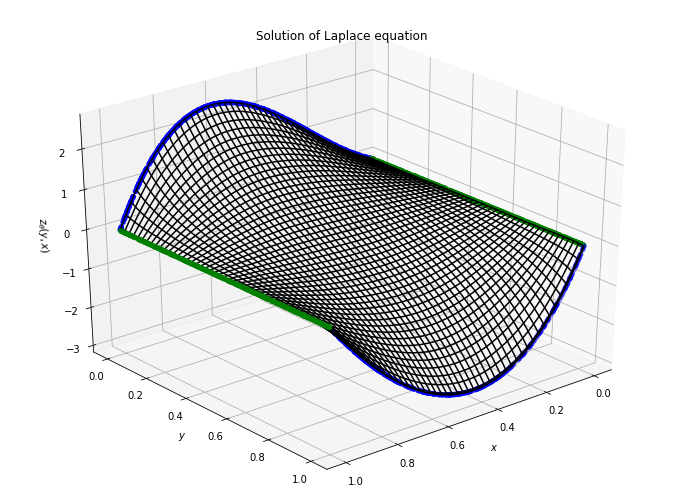

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
yspace = np.linspace(lb[0], ub[0] , N + 1)
xspace = np.linspace(lb[1], ub[1] , N + 1)
Y, X = np.meshgrid(yspace, xspace)
Xgrid = np.vstack([Y.flatten(),X.flatten()]).T  
zpred = model(tf.cast(Xgrid,DTYPE))   
Z = zpred.numpy().reshape(N+1,N+1)  

fig = plt.figure(figsize=(12,9))
#fig.set(figwidth = 12, figheight = 9)
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(Y, X, Z, color ='black');
ax.view_init(35,35)

ax.scatter3D(y_b, x_b, z_b, color = 'blue')
ax.scatter3D(y_b1, x_b1, z_b1, color = 'green')
ax.scatter3D(y_b2, x_b2, z_b2, color = 'green')
ax.scatter3D(y_b3, x_b3, z_b3, color = 'blue')


ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z_\\theta(y,x)$')
ax.set_title('Solution of Laplace equation');
ax.view_init(azim = 50)